In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
correct_cwd = False

In [3]:
import os
if correct_cwd == False:
    os.chdir("..")
    correct_cwd = True

# Toy density estimation

In [4]:
import nux
import jax
import jax.numpy as jnp
import jax.random as random
from jax import jit, vmap
import optax
import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

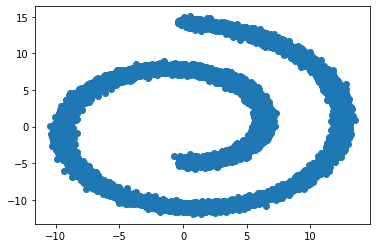

In [5]:
data = make_swiss_roll(n_samples=20000, noise=0.3, random_state=0)[0][:,[0,2]]
data = jnp.array(data)
key = random.PRNGKey(0)
data = random.permutation(key, data)
plt.scatter(*data.T)

# The flow will use dense and logistic mixture cdf layers

In [6]:
def create_flow():
    return nux.sequential(nux.AffineDense(),
                          nux.CouplingLogitsticMixtureLogit(n_components=8),
                          nux.AffineDense(),
                          nux.CouplingLogitsticMixtureLogit(n_components=8),
                          nux.AffineDense(),
                          nux.CouplingLogitsticMixtureLogit(n_components=8),
                          nux.UnitGaussianPrior())

# Initialize the flow with a batch of data

In [7]:
key = random.PRNGKey(0)
inputs = {"x": data[:128]}
flow = nux.transform_flow(create_flow)
params, state = flow.init(key, inputs, batch_axes=(0,))

# Create the objective function

In [8]:
@jit
def nll(params, state, rng, inputs):
    outputs, state = flow.apply(params, state, rng, inputs)
    log_px = outputs["log_det"] + outputs["log_pz"]
    return -jnp.mean(log_px), state

valgrad = jit(jax.value_and_grad(nll, has_aux=True))

# Train using optax

In [9]:
opt_init, opt_update = optax.adam(5e-4)
opt_update = jit(opt_update)
opt_state = opt_init(params)
apply_updates = jit(optax.apply_updates)

/home/eddie/anaconda3/envs/flow/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


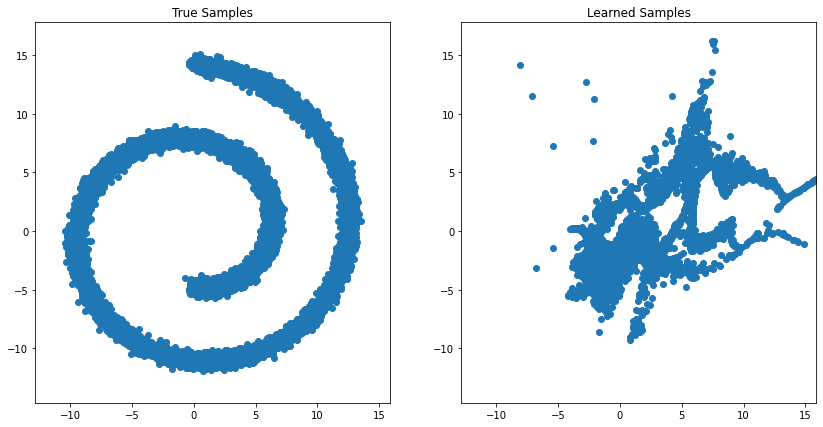

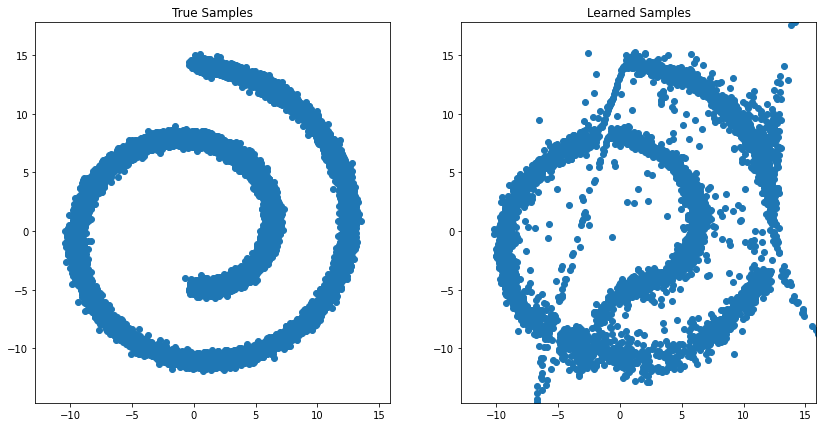

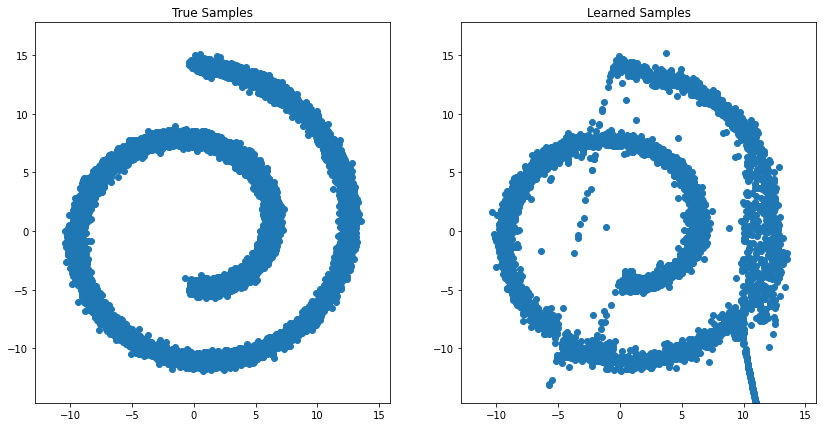

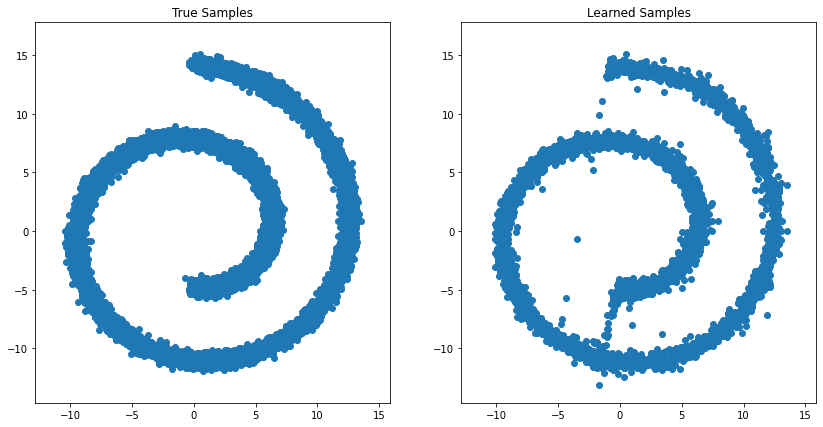

In [10]:
batch_size = 512
n_iters = 15000
key = random.PRNGKey(0)
keys = random.split(key, n_iters)
pbar = tqdm.tqdm_notebook(list(enumerate(keys)))
for i, key in pbar:
    # Take a minibatch
    batch_idx = random.randint(key, minval=0, maxval=data.shape[0], shape=(batch_size,))
    input_batch = {"x": data[batch_idx]}
    
    # Compute the gradients, updated state and loss value
    (loss, state), grad = valgrad(params, state, key, input_batch)
    pbar.set_description(f"nll: {loss:.2f}")
    
    # Apply the gradient updates
    updates, opt_state = opt_update(grad, opt_state, params)
    params = apply_updates(params, updates)
    
    # Check the progress
    if i%5000 == 0 or i == n_iters - 1:
        n_samples = 5000
        # Need a placeholder so that the prior knows what shape to sample
        placeholder = jnp.zeros((n_samples, data.shape[-1]))
        samples, _ = flow.apply(params, state, key, {"x": placeholder}, sample=True)
        
        # Plot 
        (xmin, ymin), (xmax, ymax) = data.min(axis=0), data.max(axis=0)
        xspread, yspread = xmax - xmin, ymax - ymin
        xmin -= 0.1*xspread
        xmax += 0.1*xspread
        ymin -= 0.1*yspread
        ymax += 0.1*yspread
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        ax1.scatter(*data.T); ax1.set_title("True Samples")
        ax2.scatter(*samples["x"].T); ax2.set_title("Learned Samples")
        ax1.set_xlim(xmin, xmax); ax1.set_ylim(ymin, ymax)
        ax2.set_xlim(xmin, xmax); ax2.set_ylim(ymin, ymax)
        plt.show()